### Bayesian Blocks: Histograms the Right Way

In [1]:
import numpy as np
from astroML.plotting import hist
x = np.random.normal(size = 1000)
hist(x, bins = 'blocks')

        Use astropy.visualization.hist instead. [__main__]


(array([  6.,  57., 116., 581., 190.,  36.,  14.]),
 array([-3.20237437, -2.40152743, -1.46655101, -0.85323231,  0.73912467,
         1.57916528,  2.16958432,  3.26633539]),
 <a list of 7 Patch objects>)

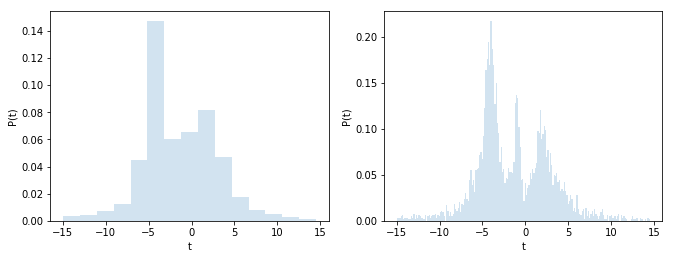

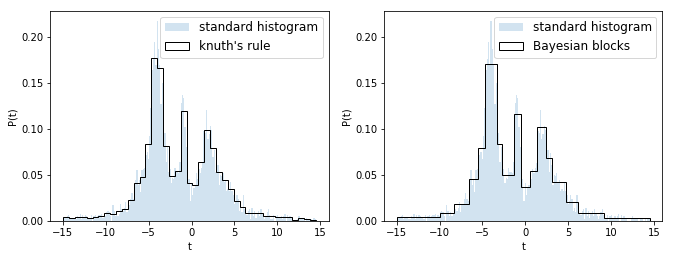

In [2]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

from astropy.visualization import hist

# draw a set of variables
np.random.seed(0)
t = np.concatenate([stats.cauchy(-5, 1.8).rvs(500),
                   stats.cauchy(-4, 0.8).rvs(2000),
                   stats.cauchy(-1, 0.3).rvs(500),
                   stats.cauchy(2, 0.8).rvs(1000),
                   stats.cauchy(4, 1.5).rvs(500)])

# truncate values to a resonable range
t = t[(t > -15) & (t < 15)]

# First figure: show normal histogram binning
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(left = 0.1, right=0.95, bottom=0.15)

ax1 = fig.add_subplot(121)
ax1.hist(t, bins = 15, histtype='stepfilled', alpha=0.2, density=True)
ax1.set_xlabel('t')
ax1.set_ylabel('P(t)')

ax2 = fig.add_subplot(122)
ax2.hist(t, bins=200, histtype='stepfilled', alpha=0.2, density=True)
ax2.set_xlabel('t')
ax2.set_ylabel('P(t)')


# Second & Third figure: Knuth bins & Bayesian Blocks
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(left = 0.1, right=0.95, bottom=0.15)

for bins, title, subplot in zip(['knuth', 'blocks'],
                               ["knuth's rule", 'Bayesian blocks'],
                               [121, 122]):
    ax = fig.add_subplot(subplot)
    
    # plot standard histogram in the background with alpha transparency
    hist(t, bins = 200, histtype = 'stepfilled',
        alpha = 0.2, density = True, label = 'standard histogram')
    
    # plot an adaptive-width histogram on top
    hist(t, bins = bins, ax = ax, color = 'black',
        histtype = 'step', density = True, label = title)
    
    ax.legend(prop=dict(size=12))
    ax.set_xlabel('t')
    ax.set_ylabel('P(t)')
    
plt.show()

### Extreme Deconvolution

@pickle_results: computing results and saving to 'XD_toy.pkl'


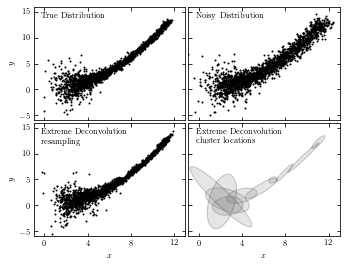

In [4]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.utils.decorators import pickle_results
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize = 8, usetex = True)

# Sample the dataset
N = 2000
np.random.seed(0)

# generate the true data
x_true = (1.4 + 2 * np.random.random(N)) ** 2
y_true = 0.1 * x_true ** 2

# add scatter to "true" distribution
dx = 0.1 + 4./ x_true ** 2
dy = 0.1 + 10. / x_true ** 2

x_true += np.random.normal(0, dx, N)
y_true += np.random.normal(0, dy, N)

# add noise to get the 'observed' distribution
dx = 0.2 + 0.5 * np.random.random(N)
dy = 0.2 + 0.5 * np.random.random(N)

x = x_true + np.random.normal(0, dx)
y = y_true + np.random.normal(0, dy)

# stack the results for computation
X= np.vstack([x, y]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T

# compute and save results
@pickle_results("XD_toy.pkl")
def compute_XD_results(n_components = 10, max_iter = 500):
    clf = XDGMM(n_components, max_iter)
    clf.fit(X, Xerr)
    return clf

clf = compute_XD_results(10, 500)
sample = clf.sample(N)

# Plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(221)
ax1.scatter(x_true, y_true, s=4, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(x, y, s=4, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(sample[:, 0], sample[:, 1], s=4, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=ax4,
                 ec='k', fc='gray', alpha=0.2)

titles = ["True Distribution", "Noisy Distribution",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]

ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-1, 13)
    ax[i].set_ylim(-6, 16)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(4))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$x$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$y$')

plt.show()

### Extreme Deconvolution of Stellar Data

number of noisy points:  (82003, 2)
number of stacked points:  (13113, 2)
size after crossmatch: (12054, 5)
@pickle_results: using precomputed results from 'XD_stellar.pkl'


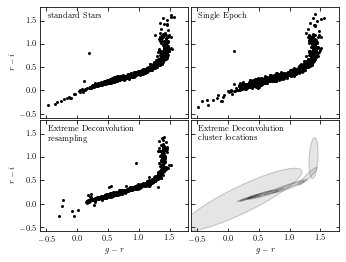

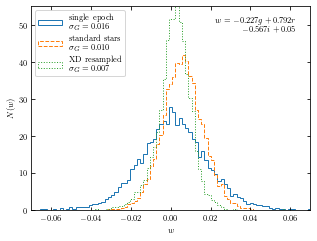

In [13]:
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from astroML.density_estimation import XDGMM
from astroML.crossmatch import crossmatch
from astroML.datasets import fetch_sdss_S82standards, fetch_imaging_sample
from astroML.plotting.tools import draw_ellipse
from astroML.utils.decorators import pickle_results
from astroML.stats import sigmaG

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

extinction_vector = np.array([1.810, 1.400, 1.0, 0.759, 0.561])

# Fetch and process the noisy imaging data
data_noisy = fetch_imaging_sample()

# select only stars
data_noisy = data_noisy[data_noisy['type'] == 6]

# Get the extinction-corrected magnitudes for each band
X = np.vstack([data_noisy[f + 'RawPSF'] for f in 'ugriz']).T
Xerr = np.vstack([data_noisy[f + 'psfErr'] for f in 'ugriz']).T

# extinction terms from Berry et el
X -= (extinction_vector * data_noisy['rExtSFD'][:, None])

# Fecth and process the stacked imaging data
data_stacked = fetch_sdss_S82standards()

# cut to RA, DEC range of imaging sample
RA = data_stacked['RA']
DEC = data_stacked['DEC']
data_stacked = data_stacked[(RA > 0) & (RA < 10) & 
                           (DEC > -1) & (DEC < 1)]

# get stacked magnitudes for each band
Y = np.vstack([data_stacked['mmu_' + f ] for f in 'ugriz']).T
Yerr = np.vstack([data_stacked['msig_' + f] for f in 'ugriz']).T

# extinction terms from Berry et al
g = Y[:, 1]
mask = ((Yerr.max(1) < 0.05) & 
       (g < 20))
data_stacked = data_stacked[mask]
Y = Y[mask]
Yerr = Yerr[mask]

# Cross match
Xlocs =  np.hstack((data_noisy['ra'][:, np.newaxis],
                   data_noisy['dec'][:, np.newaxis]))
Ylocs = np.hstack((data_stacked['RA'][:, np.newaxis],
                  data_stacked['DEC'][:, np.newaxis]))

print('number of noisy points: ', Xlocs.shape)
print('number of stacked points: ', Ylocs.shape)

# find all points within 0.9 arcsec. This cutoff was selected 
# by plotting a histogram of the log(distances).

dist, ind = crossmatch(Xlocs, Ylocs, max_distance = 0.9 / 3600)

noisy_mask = (~np.isinf(dist))
stacked_mask = ind[noisy_mask]

# select the data
data_noisy = data_noisy[noisy_mask]
X = X[noisy_mask]
Xerr = Xerr[noisy_mask]

data_stacked = data_stacked[stacked_mask]
Y = Y[stacked_mask]
Yerr = Yerr[stacked_mask]

# double-check that our cross-match succeeded
assert X.shape == Y.shape
print("size after crossmatch:", X.shape)


# Perform extreme deconvolution on the noisy sample

# first define mixing matrix W
W = np.array([[0, 1, 0, 0, 0],
             [1, -1, 0, 0, 0],
             [0, 1, -1, 0, 0],
             [0, 0, 1, -1, 0],   
              [0, 0, 0, 1, -1]])


X = np.dot(X, W.T)
Y = np.dot(Y, W.T)

# compute error covariance from mixing matirx
Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
Xcov[:, range(Xerr.shape[1]), range(Xerr.shape[1])] = Xerr ** 2

# each covariance C = WCW^T
# best way to do this with a tensor dot-product
Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))

# This is a long calculation: save results to file
@pickle_results("XD_stellar.pkl")
def compute_XD(n_clusters = 12, rseed = 0, max_iter = 100, verbose = True):
    np.random.seed(rseed)
    clf = XDGMM(n_clusters, max_iter = max_iter, tol = 1E-5, verbose = verbose)
    clf.fit(X, Xcov)
    return clf

clf = compute_XD(12)

# Fit and sample from the underlying distribution
np.random.seed(42)
X_sample = clf.sample(X.shape[0])

# plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left = 0.12, right = 0.95,
                   bottom = 0.12, top = 0.95,
                   wspace = 0.02, hspace = 0.02)

# only plot 1/10 of the stars for clarity
ax1 = fig.add_subplot(221)
ax1.scatter(Y[::10, 2], Y[::10, 3], s= 9, lw = 0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(X[::10, 2], X[::10, 3], s=9, lw = 0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(X_sample[::10, 2], X_sample[::10, 3], s= 9, lw = 0, c = 'k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i, 2:4], clf.V[i, 2:4, 2:4], scales = [2],
                ec = 'k', fc = 'gray', alpha=0.2, ax = ax4)
    
titles = ["standard Stars", "Single Epoch",
             "Extreme Deconvolution\n resampling",
             "Extreme Deconvolution\n cluster locations"]
    
ax = [ax1, ax2, ax3, ax4]


for i in range(4):
    ax[i].set_xlim(-0.6, 1.8)
    ax[i].set_ylim(-0.6, 1.8)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(0.5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$g-r$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$r-i$')
        

# Second figure : the width of the locus
fig = plt.figure(figsize=(5, 3.75))
ax = fig.add_subplot(111)

labels = ['single epoch', 'standard stars', 'XD resampled']
linestyles = ['solid', 'dashed', 'dotted']
for data, label, ls in zip((X, Y, X_sample), labels, linestyles):
    g = data[:, 0]
    gr = data[:, 2]
    ri = data[:, 3]
    
    r = g - gr
    i = r - ri
    
    mask = (gr > 0.3) & (gr < 1.0)
    g = g[mask]
    r = r[mask]
    i = i[mask]

    w = -0.227 * g + 0.792 * r - 0.567 * i + 0.05

    sigma = sigmaG(w)

    ax.hist(w, bins=np.linspace(-0.08, 0.08, 100), linestyle=ls,
            histtype='step', label=label + '\n\t' + r'$\sigma_G=%.3f$' % sigma,
            density=True)

ax.legend(loc=2)
ax.text(0.95, 0.95, '$w = -0.227g + 0.792r$\n$ - 0.567i + 0.05$',
        transform=ax.transAxes, ha='right', va='top')

ax.set_xlim(-0.07, 0.07)
ax.set_ylim(0, 55)

ax.set_xlabel('$w$')
ax.set_ylabel('$N(w)$')

plt.show()


### Kernel Density Estimation & Nearest Neighbour density Estimation

#### Great Wall Density

/home/lokesh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


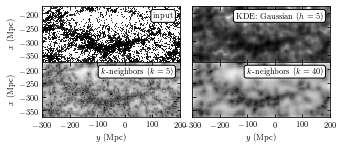

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.neighbors import KernelDensity
from astroML.datasets import fetch_great_wall
from astroML.density_estimation import KNeighborsDensity

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize = 8, usetex = True)

# Fetch the great wall data
X = fetch_great_wall()

# create3 the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

kde = KernelDensity(kernel='gaussian', bandwidth = 5)
log_pdf_kde = kde.fit(X).score_samples(Xgrid).reshape((Ny, Nx))
dens_KDE = np.exp(log_pdf_kde)

knn5 = KNeighborsDensity('bayesian', 5)
dens_k5 = knn5.fit(X).fit(X).eval(Xgrid).reshape((Ny, Nx))

knn40 = KNeighborsDensity('bayesian', 40)
dens_k40 = knn40.fit(X).eval(Xgrid).reshape((Ny, Nx))

# Plot the results
fig = plt.figure(figsize=(5, 2.2))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: KDE
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens_KDE.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "KDE: Gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: KNN, k=5
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens_k5.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.95, 0.9, "$k$-neighbors $(k=5)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Fourth plot: KNN, k=40
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens_k40.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.95, 0.9, "$k$-neighbors $(k=40)$", ha='right', va='top',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)
    
for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    
for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')
    
for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    
for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')
    
plt.show()

#### Great Wall KDE

/home/lokesh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:26: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


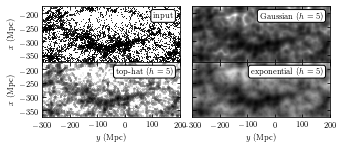

In [17]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.neighbors import KernelDensity

from astroML.datasets import fetch_great_wall

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Fetch the great wall data
X = fetch_great_wall()

#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

# Evaluate several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax , Nx),
                                           np.linspace(ymin, ymax, Ny)))).T

kernels= ['gaussian', 'tophat', 'exponential']
dens = []

kdel = KernelDensity(bandwidth=5, kernel = 'gaussian')
log_dens1 = kdel.fit(X).score_samples(Xgrid)
dens1 = X.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))

kde2 = KernelDensity(bandwidth=5, kernel='tophat')
log_dens2 = kde2.fit(X).score_samples(Xgrid)
dens2 = X.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))

kde3 = KernelDensity(bandwidth=5, kernel='exponential')
log_dens3 = kde3.fit(X).score_samples(Xgrid)
dens3 = X.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))


## Plot the results
fig = plt.figure(figsize=(5, 2.2))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: gaussian kernel
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens1.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "Gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: top-hat kernel
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens2.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.95, 0.9, "top-hat $(h=5)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax3.images[0].set_clim(0.01, 0.8)

# Fourth plot: exponential kernel
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens3.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.95, 0.9, "exponential $(h=5)$", ha='right', va='top',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()


#### Comparison of 1D Density Estimators

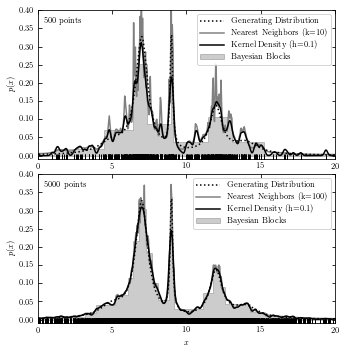

In [28]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from sklearn.neighbors import KernelDensity

from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Generate the data: a mix of several Cauchy distributions
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]

true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])

np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

# plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
N_values = (500, 5000)
subplots = (211, 212)
k_values = (10, 100)

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)

    # Compute density with KDE
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(xN[:, None])
    dens_kde = np.exp(kde.score_samples(t[:, None]))

    # Compute density with Bayesian nearest neighbors
    nbrs = KNeighborsDensity('bayesian', n_neighbors=k).fit(xN[:, None])
    dens_nbrs = nbrs.eval(t[:, None]) / N

    # plot the results
    ax.plot(t, true_pdf(t), ':', color='black', zorder=3,
            label="Generating Distribution")
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')
    hist(xN, bins='blocks', ax=ax, density=True, zorder=1,
             histtype='stepfilled', color='k', alpha=0.2,
             label="Bayesian Blocks")
    ax.plot(t, dens_nbrs, '-', lw=1.5, color='gray', zorder=2,
            label="Nearest Neighbors (k=%i)" % k)
    ax.plot(t, dens_kde, '-', color='black', zorder=3,
            label="Kernel Density (h=0.1)")

    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right')

    if subplot == 212:
        ax.set_xlabel('$x$')

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.01, 0.4001)

plt.show()

#### Above is a comparison of different density estimation methods for two simulated one-dimensional datasets.